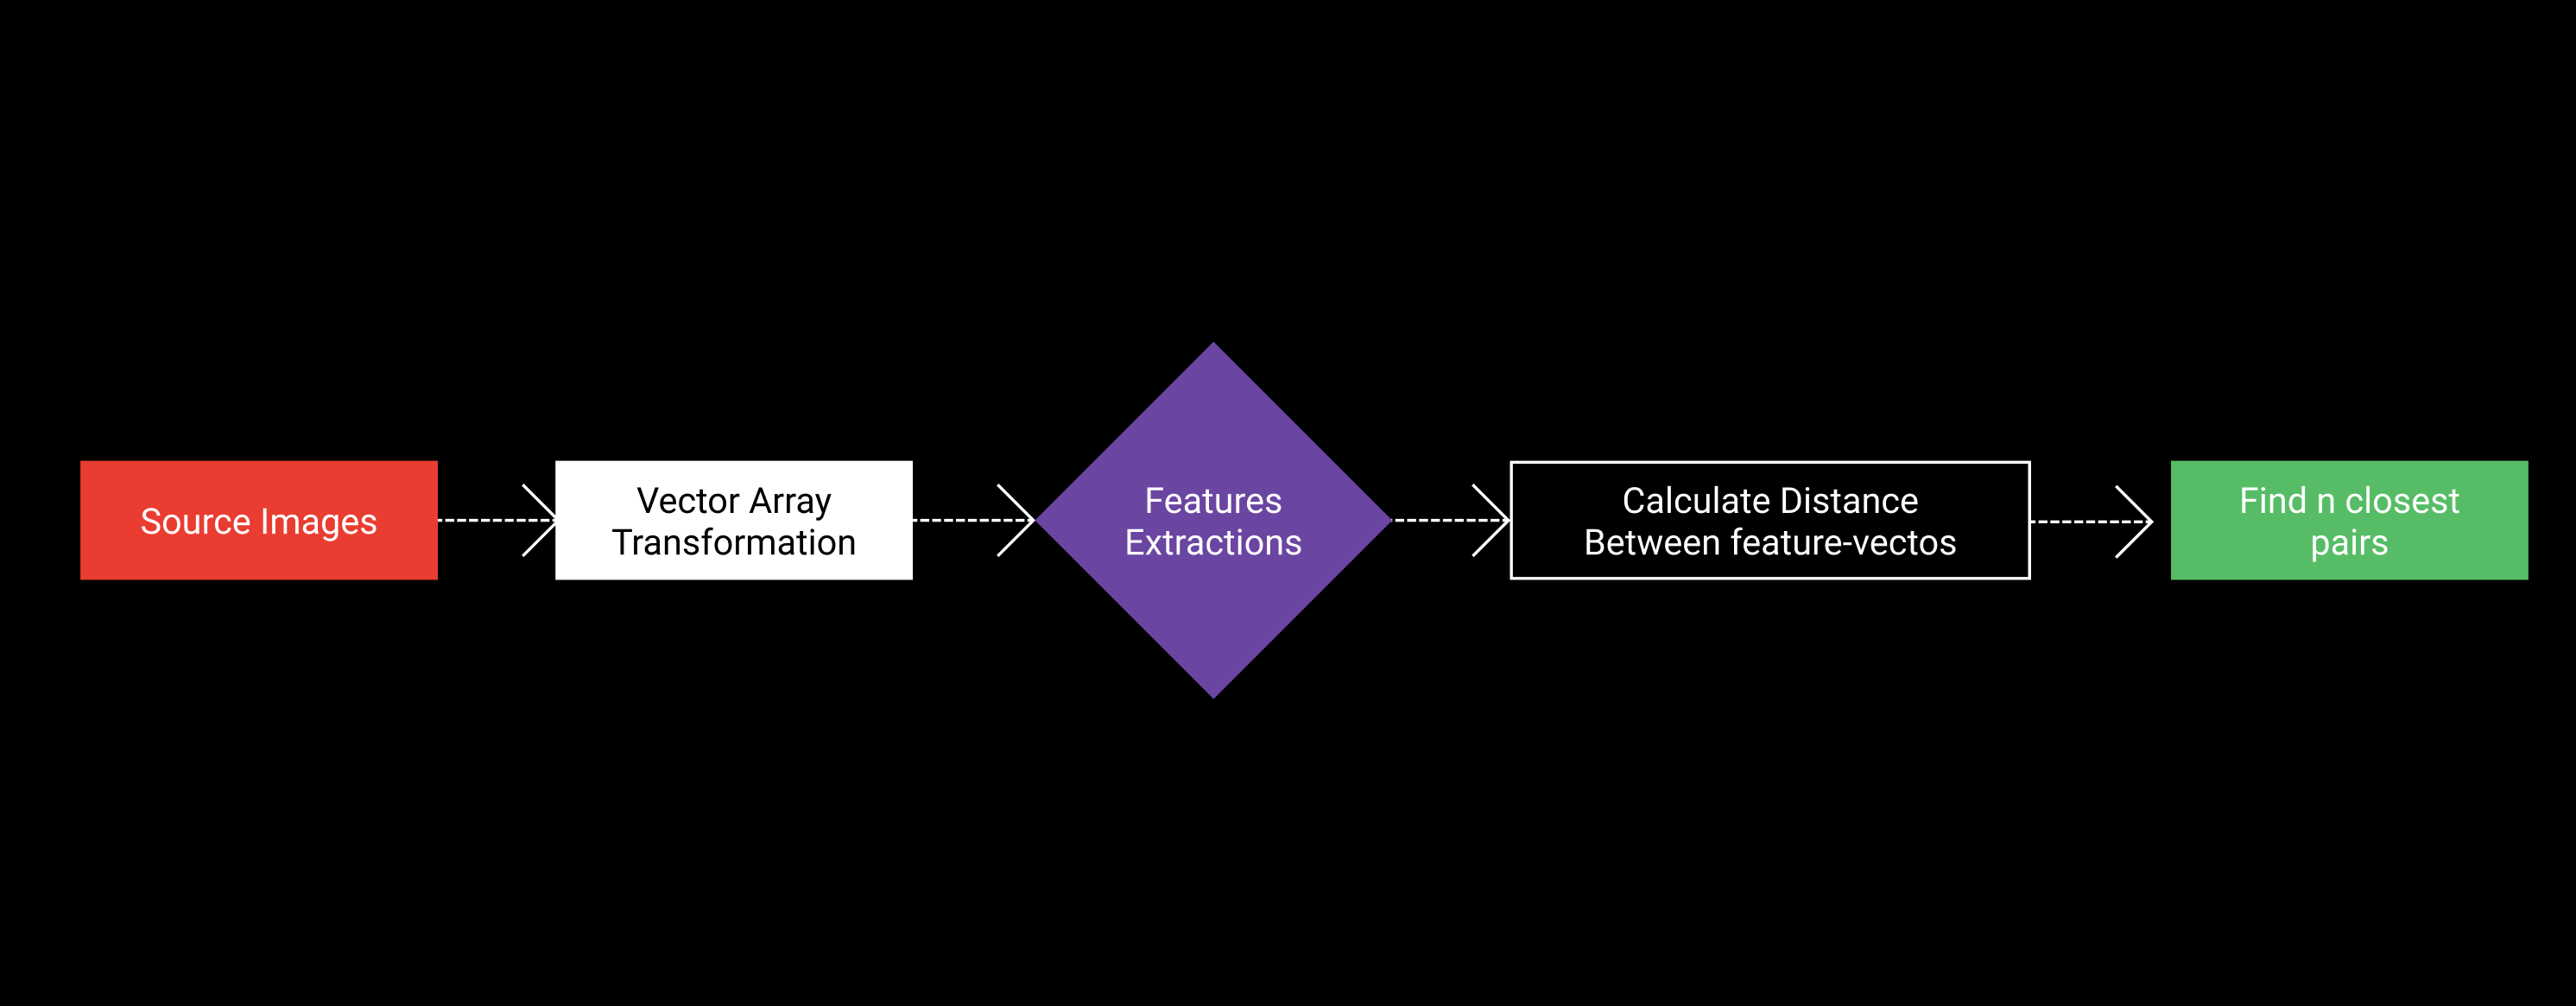

Imports and a small function for correctly naming the resulting pairs:

In [ ]:
import cv2
import os
from tensorflow.keras.applications.vgg19 import VGG19,  preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16,  preprocess_input

from tensorflow.keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.efficientnet import EfficientNetB0, preprocess_input
import numpy as np
import pickle
import shutil
import math
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

from google.colab import drive
drive.mount('/content/drive')

#convert cardinals to ordinals
list_of_suffixes = {1: 'st', 2: 'nd', 3: 'rd'}
def ordinal(num):
    if 10 <= num % 100 <= 20:                         #mind exceptions 10-20
        suffix = 'th'
    else:
        suffix = list_of_suffixes.get(num % 10, 'th') #th by default
    return str(num) + suffix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Defining all the directories and the number of matches for every target image:

In [ ]:
#define necessary paths here

#video_directory = '/content/drive/MyDrive/sample.mp4'
training_directory = '/content/drive/MyDrive/stem_day/data/train'
testimages_directory = '/content/drive/MyDrive/stem_day/data/test'
#results_directory = '/content/drive/MyDrive/stem_day/data/results'
logs_directory = '/content/drive/MyDrive/logs.txt'
#pickle_directory = '/content/drive/MyDrive/pickled_features_dict.pkl'



Extracting frames from sample video (if the pool of images is already available, this step is not needed):

By importing a CNN without the top layers, it is possible to obtain the feature vectors from every image the network processes. After that, the features are compared and ranked, in this case by measuring the Euclidean distance between the pairs:

In [ ]:
def get_features(img, model):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    test_features = model.predict(x)
    return test_features

In [ ]:
m = input('What model do you want to choose (VGG16, VGG19, ResNet50, EfficientNetB0): ')

if m == 'VGG16':
    model = VGG16(weights='imagenet', include_top=False)
elif m == 'VGG19':
    model = VGG19(weights='imagenet', include_top=False)
elif m == 'ResNet50':
    model = ResNet50(weights='imagenet', include_top=False)
elif m == 'EfficientNetB0':
    model = EfficientNetB0(weights='imagenet', include_top=False)
else:
    print('Invalid model')
    exit()

What model do you want to choose (VGG16, VGG19, ResNet50, EfficientNetB0): ResNet50


In [ ]:
#extract features from each video-frame to dict
logs = open(logs_directory, 'w')
features_dict = dict()

#import model without classifier
#model = ResNet50(weights='imagenet', include_top=False)

# loop files in directory
for filename in os.listdir(training_directory):
    f = os.path.join(training_directory, filename)
    test_img = image.load_img(f, target_size=(224, 224))
    #convert image to vector representation
    test_features = get_features(test_img, model)
    logs.write(f"Image {filename} processed\n")
    #save to dict
    features_dict[filename] = test_features


1/1 [==============================] - 0s 332ms/step


The bulk of the time spent running this script relates to feature extraction—calculating the Euclidean distance is a relatively rapid process. To save time on repeated tests, it's possible to save and load the extracted features to and from memory:

Finally, the target images are processed and their features are compared to the previous data structure:

In [ ]:
#model = ResNet50(weights='imagenet', include_top=False)

cosDict = dict()
imgDict = dict()
corrDict = dict()
image_count = 0

In [ ]:
def cosine_similarity(a, b):
    return np.dot(a.flatten(), b.flatten()) / (np.linalg.norm(a) * np.linalg.norm(b))

def euclidean_distance_calc(a, b):
    return np.linalg.norm(a - b)

def correlation_coefficient(a, b):
    a_flat = a.flatten()
    b_flat = b.flatten()
    return np.corrcoef(a_flat, b_flat)[0, 1]

In [ ]:
# give a picture

target_dict = dict()


for filename in os.listdir(testimages_directory):
    image_count+=1
    target_img_path = os.path.join(testimages_directory, filename)

    #prepare image to be fed to model
    target_img = image.load_img(target_img_path, target_size=(224, 224))

    #extract features-vector
    target_features = get_features(target_img, model)

    target_dict[filename] = target_features
    #save to folder for analysis
    #shutil.copy(target_img_path, results_directory + f"/frame{image_count}.jpg")

    #clean data struct for current attempt
    imgDict.clear()

choose_file_1 = input("Input 1st picture path to compare the similarity distance score: ")
choose_file_2 = input("Input 2nd picture path to compare the similarity distance score: ")

#print(choose_file)
# test_features_1 = None
# test_features_2 = None

if choose_file_1 not in features_dict:
    test_img = image.load_img(choose_file_1, target_size=(224, 224))
    print(test_img)
    #convert image to vector representation
    test_features_1 = get_features(test_img, model)
    #save to dict
    # choose_file = choose_file.split('/')[-1]
    # print(choose_file)
    features_dict[choose_file_1] = test_features_1
else:
    test_features_1 = features_dict[choose_file_1]

if choose_file_2 not in features_dict:
    test_img = image.load_img(choose_file_2, target_size=(224, 224))
    #print(test_img)
    #convert image to vector representation
    test_features_2 = get_features(test_img, model)
    #save to dict
    # choose_file = choose_file.split('/')[-1]
    # print(choose_file)
    features_dict[choose_file_2] = test_features_2
else:
    test_features_2 = features_dict[choose_file_2]

euclidean_distance = euclidean_distance_calc(test_features_1, test_features_2)

cosine_sim = cosine_similarity(test_features_1, test_features_2)*100

corr = correlation_coefficient(test_features_1, test_features_2)*100


print(f'Eucliean similarity between 1st picture: {choose_file_1} and 2nd Picture is: {choose_file_2} is: {euclidean_distance}')
print(f'Cosine similarity between 1st picture: {choose_file_1} and 2nd Picture is: {choose_file_2} is: {cosine_sim:.2f}%')
print(f'Correlation coefficient between 1st picture: {choose_file_1} and 2nd Picture is: {choose_file_2} is: {corr:.2f}%')
print(" ")

# for key, value in target_dict.items():
#     test_features = features_dict[choose_file]
#     #calc euclidean distance between tensors
#     #temp = value - test_features
#     euclidean_distance = euclidean_distance_calc(value, test_features)

#     cosine_sim = cosine_similarity(value, test_features)*100

#     corr = correlation_coefficient(value, test_features)*100


#     print(f'Eucliean similarity between Target: {key} and Input Picture: {choose_file} is: {euclidean_distance}')
#     print(f'Cosine similarity between Target: {key} and Input Picture: {choose_file} is: {cosine_sim:.2f}%')
#     print(f'Correlation coefficient between Target: {key} and Input Picture: {choose_file} is: {corr:.2f}%')
#     print(" ")



1/1 [==============================] - 0s 194ms/step
Input 1st picture path to compare the similarity distance score: /content/drive/MyDrive/stem_day/data/images/salad2.jpg
Input 2nd picture path to compare the similarity distance score: /content/drive/MyDrive/stem_day/data/images/burger.jpg
<PIL.Image.Image image mode=RGB size=224x224 at 0x7ACB08B17CD0>
1/1 [==============================] - 0s 200ms/step
Eucliean similarity between 1st picture: /content/drive/MyDrive/stem_day/data/images/salad2.jpg and 2nd Picture is: /content/drive/MyDrive/stem_day/data/images/burger.jpg is: 742.4932861328125
Cosine similarity between 1st picture: /content/drive/MyDrive/stem_day/data/images/salad2.jpg and 2nd Picture is: /content/drive/MyDrive/stem_day/data/images/burger.jpg is: 27.94%
Correlation coefficient between 1st picture: /content/drive/MyDrive/stem_day/data/images/salad2.jpg and 2nd Picture is: /content/drive/MyDrive/stem_day/data/images/burger.jpg is: 20.99%
 


1/1 [==============================] - 0s 197ms/step


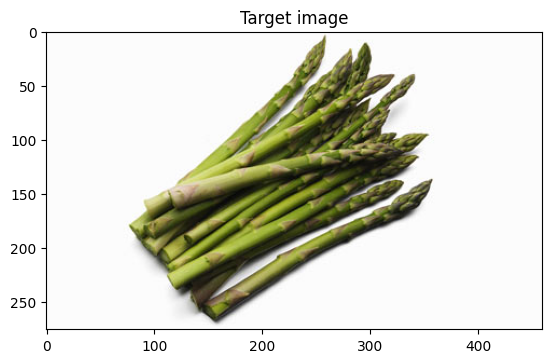

1st match Euclidean distance: 545.1398315429688
Cosine Similarity: 52.66%
Correlation Coefficient: 49.08%


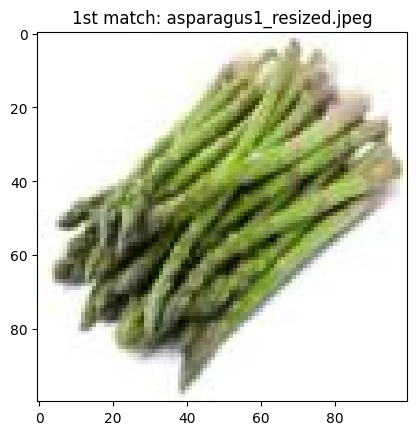

2nd match Euclidean distance: 598.1021118164062
Cosine Similarity: 44.73%
Correlation Coefficient: 40.92%


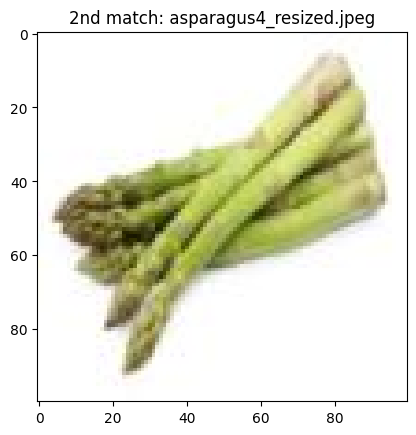

3rd match Euclidean distance: 573.0165405273438
Cosine Similarity: 44.57%
Correlation Coefficient: 40.79%


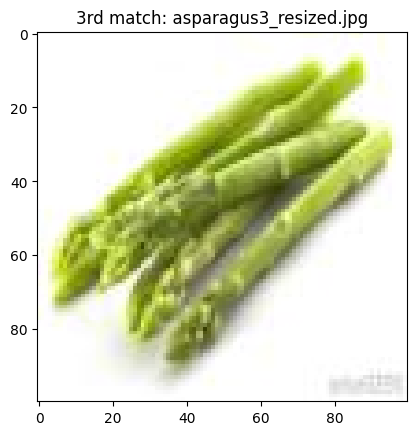

4th match Euclidean distance: 591.2169799804688
Cosine Similarity: 44.34%
Correlation Coefficient: 40.36%


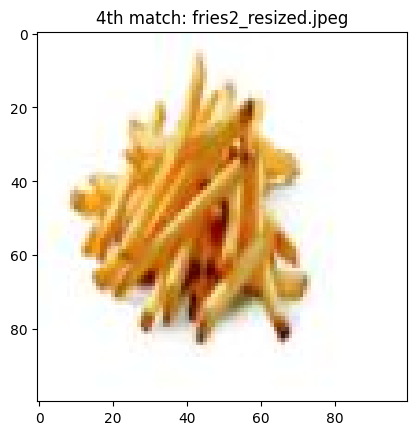

5th match Euclidean distance: 597.6845092773438
Cosine Similarity: 41.56%
Correlation Coefficient: 37.22%


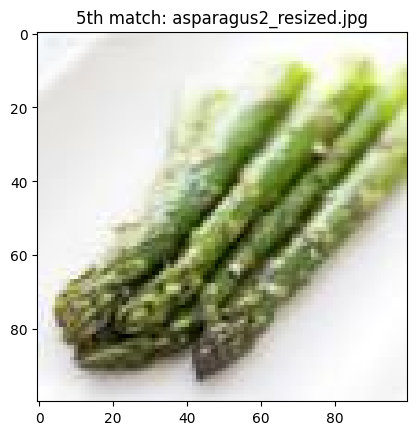

1/1 [==============================] - 0s 344ms/step


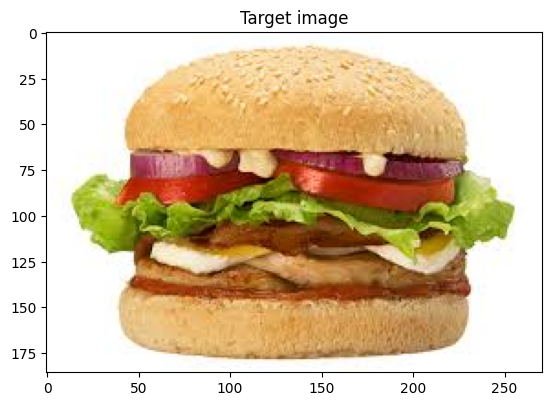

1st match Euclidean distance: 618.7830200195312
Cosine Similarity: 47.75%
Correlation Coefficient: 43.36%


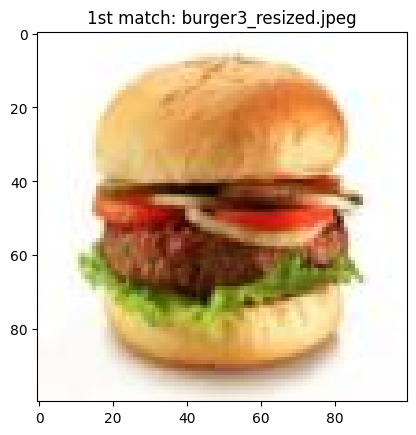

2nd match Euclidean distance: 603.6077880859375
Cosine Similarity: 45.58%
Correlation Coefficient: 41.03%


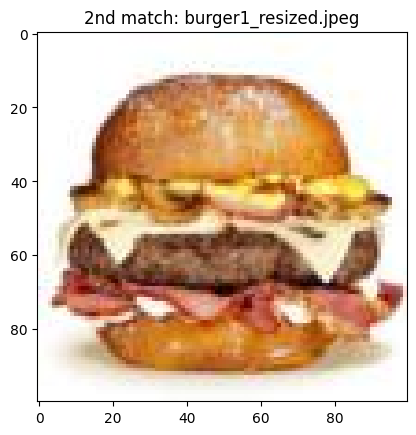

3rd match Euclidean distance: 616.2080688476562
Cosine Similarity: 44.32%
Correlation Coefficient: 39.77%


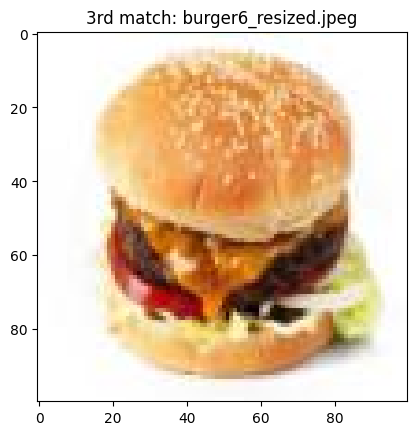

4th match Euclidean distance: 638.7222290039062
Cosine Similarity: 42.39%
Correlation Coefficient: 37.68%


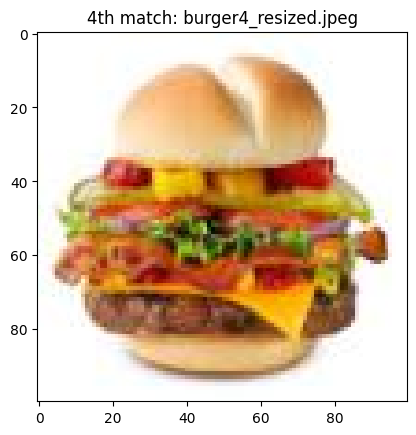

5th match Euclidean distance: 645.0410766601562
Cosine Similarity: 40.52%
Correlation Coefficient: 35.34%


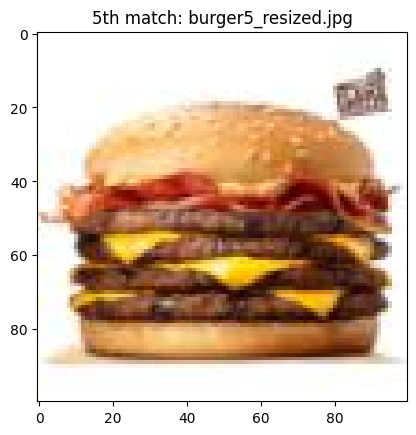

1/1 [==============================] - 0s 353ms/step


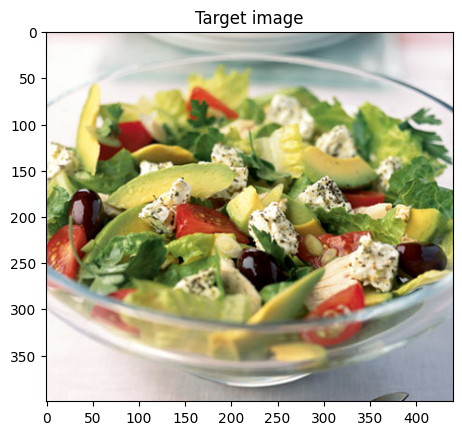

1st match Euclidean distance: 590.6259155273438
Cosine Similarity: 42.10%
Correlation Coefficient: 36.98%


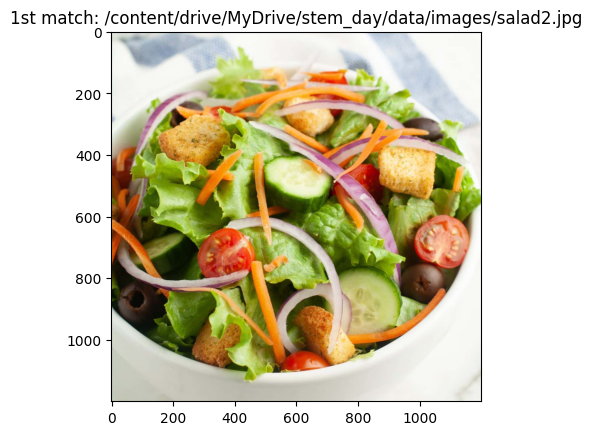

2nd match Euclidean distance: 633.8737182617188
Cosine Similarity: 38.17%
Correlation Coefficient: 32.73%


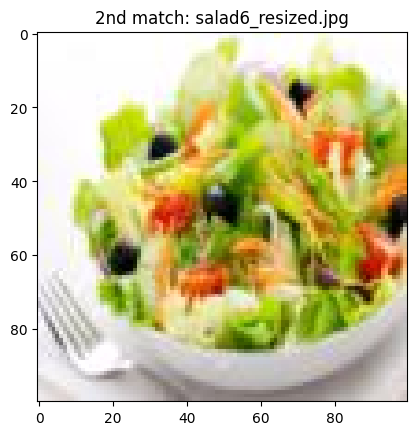

3rd match Euclidean distance: 644.3886108398438
Cosine Similarity: 30.64%
Correlation Coefficient: 25.45%


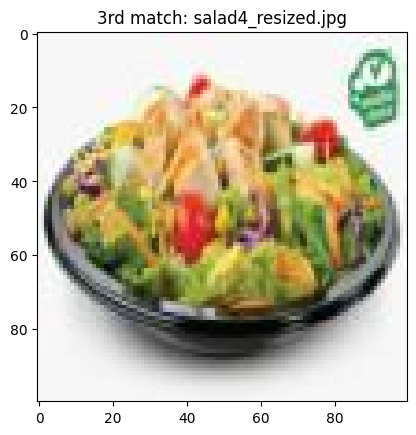

4th match Euclidean distance: 643.4876708984375
Cosine Similarity: 27.69%
Correlation Coefficient: 21.73%


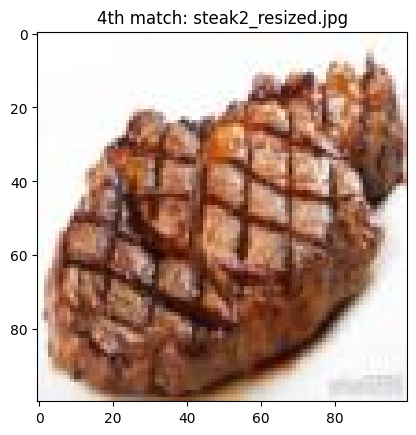

5th match Euclidean distance: 650.5562744140625
Cosine Similarity: 27.41%
Correlation Coefficient: 21.64%


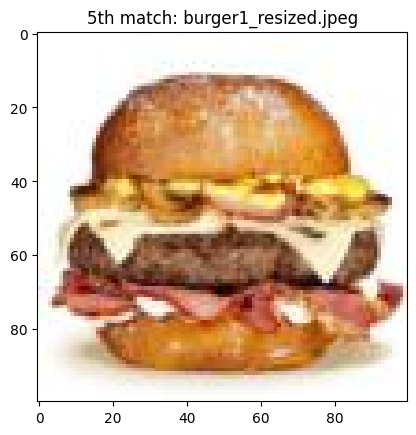

In [ ]:
#test every image on diretory

#define number of matches here

number_of_matches = 5

# loop files in directory
for filename in os.listdir(testimages_directory):
    image_count+=1
    target_img_path = os.path.join(testimages_directory, filename)

    #prepare image to be fed to model
    target_img = image.load_img(target_img_path, target_size=(224, 224))

    #extract features-vector
    target_features = get_features(target_img, model)

    #print target_img
    plt.title("Target image")
    first_image = mpimg.imread(target_img_path)
    plt.imshow(first_image)
    plt.show()

    #set the min to the max every time
    #distance = 1000000
    target_dict[filename] = target_features
    #save to folder for analysis
    #shutil.copy(target_img_path, results_directory + f"/frame{image_count}.jpg")

    #clean data struct for current attempt
    imgDict.clear()

    #take features from dict, compare to target, write distance to imgDict
    for key in features_dict.keys():
        test_features = features_dict[key]
        #calc euclidean distance between tensors
        euclidean_distance = euclidean_distance_calc(target_features, test_features)
        imgDict[key] = euclidean_distance


        cos_distance = cosine_similarity(target_features, test_features)*100
        cosDict[key] = cos_distance

        corr = correlation_coefficient(target_features, test_features)*100
        corrDict[key] = corr


        #print(f'Key: {key} , Distance to Target: {new_distance}')

    # top_matches = sorted(imgDict.items(), key=lambda x: x[1])[:number_of_matches]

    # Display and save results for top k matches
    for i in range(number_of_matches):
        best_img = max(corrDict, key=cosDict.get)

        ordinal_label = ordinal(i+1)


        #print best_img

        print(f'{ordinal_label} match Euclidean distance: {imgDict[best_img]}')
        print(f'Cosine Similarity: {cosDict[best_img]:.2f}%')
        print(f'Correlation Coefficient: {corrDict[best_img]:.2f}%')
        plt.title(f"{ordinal_label} match: {best_img}")

        best_img_path = os.path.join(training_directory, best_img)
        final_image = mpimg.imread(best_img_path)
        plt.imshow(final_image)
        plt.show()

        #after reporting result i, eliminate from dict to go to i+1
        del corrDict[best_img]
